
# Select the stock symbol and date range.


In [156]:
#stock symbol
ticker = "TRTN"
# mm-dd-yy formate
start_date = "01-01-2018"
end_date =  "01-21-2020"

In [157]:
# Import Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from fbprophet import Prophet

# Statsmodels widely known for forecasting than Prophet
import statsmodels.api as sm
from scipy import stats
import datetime
from plotly import tools
import plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")
from pandas_datareader import data as pdr

import yfinance as yf



# plt.style.available
plt.style.use("seaborn-whitegrid")

In [158]:
df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date )

In [159]:
# Brief Description of our dataset
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,516.000000,516.000000,516.000000,516.000000,5.160000e+02,516.000000
mean,34.242016,33.259981,33.761298,33.745484,4.477391e+05,31.743443
std,3.001782,3.060559,3.048768,3.054540,3.163380e+05,3.340330
min,29.250000,27.760000,28.100000,28.160000,9.880000e+04,24.940802
25%,31.750000,30.760000,31.240000,31.272501,2.874750e+05,29.372996
50%,33.555000,32.615000,33.135000,33.085001,3.704000e+05,31.384618
75%,36.335001,35.299999,35.860001,35.935000,4.883000e+05,33.723871
max,42.410000,40.810001,42.000000,41.849998,3.424500e+06,40.500000


We need to make sure if the date column is either a categorical type or a datetype. In our case date is a categorical datatype so we need to change it to datetime.

In [160]:
df.info() # Check whether the date is as object type or date type

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516 entries, 2018-01-02 to 2020-01-21
Data columns (total 6 columns):
High         516 non-null float64
Low          516 non-null float64
Open         516 non-null float64
Close        516 non-null float64
Volume       516 non-null float64
Adj Close    516 non-null float64
dtypes: float64(6)
memory usage: 28.2 KB


In [161]:
#  Change to dateformat
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,39.259998,37.689999,37.880001,39.090000,393100.0,34.621300
2018-01-03,39.889999,37.889999,39.150002,38.310001,483600.0,33.930470
2018-01-04,39.040001,38.389999,38.619999,38.810001,363800.0,34.373314
2018-01-05,39.119999,38.400002,38.980000,39.000000,213600.0,34.541592
2018-01-08,39.689999,38.630001,39.009998,39.580002,374900.0,35.055283


In [162]:
df['date'] = df.index

In [163]:
# Create a copy to avoid the SettingWarning .loc issue 
dte_df = df.copy()
# Change to datetime datatype.
dte_df.loc[:, 'date'] = pd.to_datetime(dte_df.loc[:,'date'], format="%Y/%m/%d")

In [164]:
dte_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516 entries, 2018-01-02 to 2020-01-21
Data columns (total 7 columns):
High         516 non-null float64
Low          516 non-null float64
Open         516 non-null float64
Close        516 non-null float64
Volume       516 non-null float64
Adj Close    516 non-null float64
date         516 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 32.2 KB


In [165]:
dte_df.head()

,High,Low,Open,Close,Volume,Adj Close,date
Date,,,,,,,
2018-01-02,39.259998,37.689999,37.880001,39.090000,393100.0,34.621300,2018-01-02
2018-01-03,39.889999,37.889999,39.150002,38.310001,483600.0,33.930470,2018-01-03
2018-01-04,39.040001,38.389999,38.619999,38.810001,363800.0,34.373314,2018-01-04
2018-01-05,39.119999,38.400002,38.980000,39.000000,213600.0,34.541592,2018-01-05
2018-01-08,39.689999,38.630001,39.009998,39.580002,374900.0,35.055283,2018-01-08


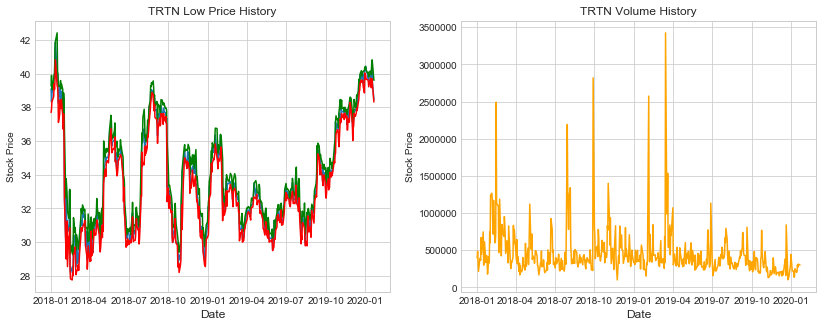

In [166]:
# Simple plotting of Amazon Stock Price
# First Subplot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.plot(dte_df["date"], dte_df["Close"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title(f"{ticker} Close Price History")

# Second Subplot
ax1.plot(dte_df["date"], dte_df["High"], color="green")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title(f"{ticker} High Price History")

# Third Subplot
ax1.plot(dte_df["date"], dte_df["Low"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title(f"{ticker} Low Price History")

# Fourth Subplot
ax2.plot(dte_df["date"], dte_df["Volume"], color="orange")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title(f"{ticker} Volume History")
plt.show()

### Prophet Introduction:
Prophet is Facebook's library for time series forecasting. In my opinion, Prophet works best with datasets that are higely influenced by seasonality (electricity bills, restaurant visitors etc.) However, I wanted to show the simplicity of using Prophet for simple forecasting which is the main aim of this kernel.

#### Steps for using Prophet:
<ul>
<li>Make sure you replace closing price for y and date for ds. </li>
<li>Fit that dataframe to Prophet in order to detect future patterns. </li>
<li>Predict the upper and lower prices of the closing price. </li>
</ul>

In [167]:
m = Prophet()

# Drop the columns
ph_df = dte_df.drop(['Open', 'High', 'Low','Volume'], axis=1)
ph_df.rename(columns={'Close': 'y', 'date': 'ds'}, inplace=True)

ph_df.head()

,y,Adj Close,ds
Date,,,
2018-01-02,39.090000,34.621300,2018-01-02
2018-01-03,38.310001,33.930470,2018-01-03
2018-01-04,38.810001,34.373314,2018-01-04
2018-01-05,39.000000,34.541592,2018-01-05
2018-01-08,39.580002,35.055283,2018-01-08


In [168]:
m = Prophet(yearly_seasonality=True, daily_seasonality=True)

m.fit(ph_df)

In [169]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=365, freq='D')

# Predict Prices
pd.plotting.register_matplotlib_converters()
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
876,2021-01-16,62.950232,55.707064,69.185450
877,2021-01-17,63.057654,56.353667,69.142177
878,2021-01-18,62.564059,55.520204,69.360737
879,2021-01-19,62.763740,56.003973,69.290599
880,2021-01-20,62.760929,55.851163,69.355429


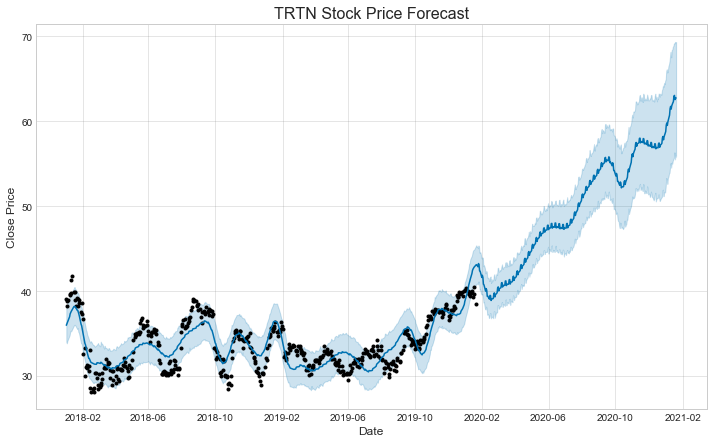

In [170]:
import matplotlib.dates as mdates



# Dates
starting_date = dt.datetime(2018, 1, 1)
starting_date1 = mdates.date2num(starting_date)
trend_date = dt.datetime(2020, 1, 1)
trend_date1 = mdates.date2num(trend_date)


# Learn more Prophet tomorrow and plot the forecast for ticker.
from fbprophet.plot import plot
fig = m.plot(forecast)
ax1 = fig.add_subplot(111)
ax1.set_title(f"{ticker} Stock Price Forecast", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Close Price", fontsize=12)


plt.show()

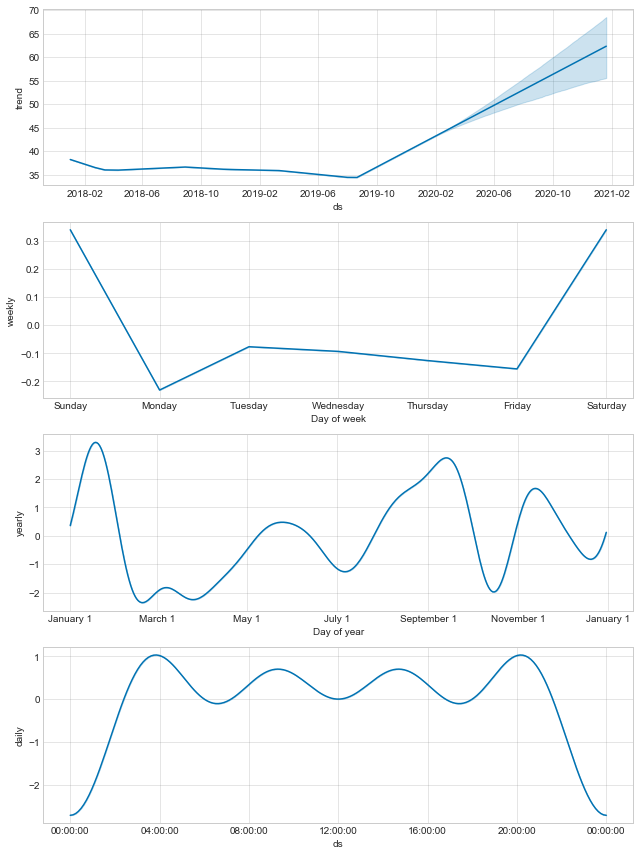

In [171]:
fig2 = m.plot_components(forecast)
plt.show()

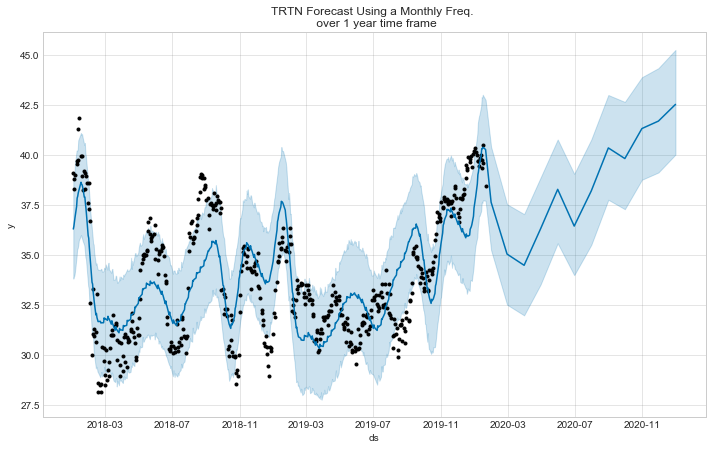

In [172]:
# Monthly Data Predictions
m = Prophet(yearly_seasonality=True,weekly_seasonality=True, daily_seasonality=True, changepoint_prior_scale=0.01).fit(ph_df)
future = m.make_future_dataframe(periods=12, freq="M")
fcst = m.predict(future)
fig = m.plot(fcst)
plt.title(f"{ticker} Forecast Using a Monthly Freq. \n over 1 year time frame")

plt.show()

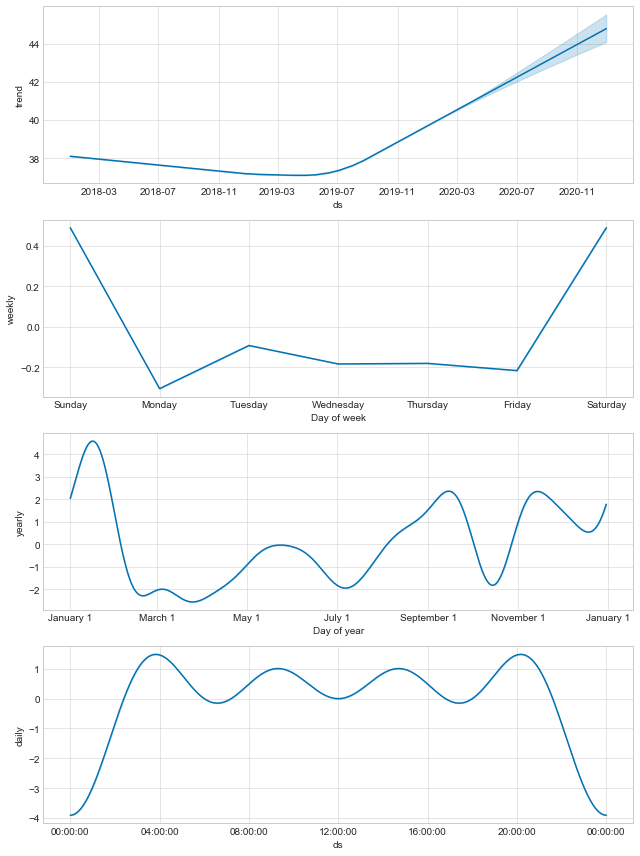

In [173]:
fig = m.plot_components(fcst)
plt.show()

<h2>Technical Analysis: </h2>
In this section we will go into basic technical concepts when dealing with stock investing. This are simple theories however, we shouldn't solely rely on these concepts to maximize profits as it is the case with patterns related to moving averages. Before going into this concepts, I will like to show how OHLC and Candlesticks are interpreted.

<h3 align="center">Open High Low Close (OHLC): </h3>
<img src="https://image.slidesharecdn.com/forexcandlestick-151105160826-lva1-app6892/95/forex-candlestick-5-638.jpg?cb=1446739926" ></img>
<br><br>
<h3 align="center">CandleSticks: </h3>
<img src="http://wealthv.com/learn/actionforex/images/candlestick_charts_explained_1.gif" ></img>
<br><br>
<h3 align="center">Moving Averages: </h3>
<img src="https://commodity.com/wp-content/uploads/technical-analysis/MASimple50200SPY.gif" ></img>

In [174]:
trace = go.Ohlc(x=dte_df['date'],
                open=dte_df['Open'],
                high=dte_df['High'],
                low=dte_df['Low'],
                close=dte_df['Close'],
               increasing=dict(line=dict(color= '#58FA58')),
                decreasing=dict(line=dict(color= '#FA5858')))

layout = {
    'title': f'{ticker} Historical Price',
    'xaxis': {'title': 'date',
             'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'},
    'shapes': [{
        'x0': '2016-12-09', 'x1': '2016-12-09',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
    }]
}

data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

In [175]:
last_two = dte_df.loc[dte_df['date'].dt.year > 2016]

g = last_two.groupby(dte_df['date'])
monthly_averages = g.aggregate({"Open": np.mean, "High": np.mean, "Low": np.mean, "Close":np.mean})
monthly_averages.reset_index(level=0, inplace=True)

trace = go.Candlestick(x=monthly_averages['date'],
                       open=monthly_averages['Open'].values.tolist(),
                       high=monthly_averages['High'].values.tolist(),
                       low=monthly_averages['Low'].values.tolist(),
                       close=monthly_averages['Close'].values.tolist(),
                      increasing=dict(line=dict(color= '#58FA58')),
                decreasing=dict(line=dict(color= '#FA5858')))

layout = {
    'title': f'{ticker} Historical Price <br> <i>For the Last two years </i>',
    'xaxis': {'title': 'Date',
             'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'},
    'shapes': [{
        'x0': '2018-01-02', 'x1': '2018-01-02',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
    }]
    
}


data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

In [176]:
dte_df['month_year'] = pd.to_datetime(dte_df['date']).dt.to_period('M')

# 2017 onwards
last_year = dte_df.loc[dte_df['date'].dt.year > 2017]
g = last_year.groupby(["date"])
monthly_averages = g.aggregate({"Open": np.mean, "High": np.mean, "Low": np.mean, "Close":np.mean})
monthly_averages.reset_index(level=0, inplace=True)

monthly_averages.dtypes


trace = go.Candlestick(x=monthly_averages['date'],
                       open=monthly_averages['Open'].values.tolist(),
                       high=monthly_averages['High'].values.tolist(),
                       low=monthly_averages['Low'].values.tolist(),
                       close=monthly_averages['Close'].values.tolist(),
                      increasing=dict(line=dict(color= '#58FA58')),
                decreasing=dict(line=dict(color= '#FA5858')))


layout = {
    'title': f'{ticker} Historical Price <br> <i>A closer look to the upward trend </i>',
    'xaxis': {'title': 'Date',
             'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'}
}


data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

In [177]:
dte_df.head()

,High,Low,Open,Close,Volume,Adj Close,date,month_year
Date,,,,,,,,
2018-01-02,39.259998,37.689999,37.880001,39.090000,393100.0,34.621300,2018-01-02,2018-01
2018-01-03,39.889999,37.889999,39.150002,38.310001,483600.0,33.930470,2018-01-03,2018-01
2018-01-04,39.040001,38.389999,38.619999,38.810001,363800.0,34.373314,2018-01-04,2018-01
2018-01-05,39.119999,38.400002,38.980000,39.000000,213600.0,34.541592,2018-01-05,2018-01
2018-01-08,39.689999,38.630001,39.009998,39.580002,374900.0,35.055283,2018-01-08,2018-01


In [178]:
# Moving Averages (10, 50 and 200)
dte_df['10_d_avg'] = dte_df.Close.rolling(window=10).mean()
dte_df['50_d_avg'] = dte_df.Close.rolling(window=50).mean()
dte_df['200_d_avg'] = dte_df.Close.rolling(window=200).mean()
close_p = dte_df['Close'].values.tolist()


# Variables to insert into plotly
ten_d = dte_df['10_d_avg'].values.tolist()
fifty_d = dte_df['50_d_avg'].values.tolist()
twoh_d = dte_df['200_d_avg'].values.tolist()
date = dte_df['date'].values.tolist()

# Set date as index
dte_df = dte_df.set_index('date')

In [179]:
fig = tls.make_subplots(rows=2, cols=1, shared_xaxes=True)

colors = ['#ff4500', '#92a1cf', '#6E6E6E']
avgs = ['10_d_avg', '50_d_avg', '200_d_avg']
# for i,c in zip(range(n),color):
#    ax1.plot(x, y,c=c)

for col, c in zip(avgs, colors):
    fig.append_trace({'x': dte_df.index, 'y': dte_df[col], 'type': 'scatter', 'name': col, 'line': {'color': c}}, 1, 1)
for col in ['Close']:
    fig.append_trace({'x': dte_df.index, 'y': dte_df[col], 'type': 'scatter', 'name': 'Closing Price', 'line':{'color': '#01DF3A'}}, 2, 1)
    
fig['layout'].update(height=800,title=f'{ticker} Relationship between MAs <br> and Closing Price',
                    paper_bgcolor='#F2DFCE', plot_bgcolor='#F2DFCE')
    
iplot(fig, filename='pandas/mixed-type subplots')

In [180]:
# Take off the date index
dte_df = dte_df.reset_index()

# Plotly
trace0 = go.Scatter(
    x = dte_df['date'],
    y = ten_d,
    name = '10-day MA',
    line = dict(
        color = ('#ff6347'),
        width = 4)
)
trace1 = go.Scatter(
    x = dte_df['date'],
    y = fifty_d,
    name = '50-day MA',
    line = dict(
        color = ('#92a1cf'),
        width = 4,
    dash="dot")
)
trace2 = go.Scatter(
    x = dte_df['date'],
    y = twoh_d,
    name = '200-day MA',
    line = dict(
        color = ('#2EF688'),
        width = 4,
        dash = 'dash') # dash options include 'dash', 'dot', and 'dashdot'
)

data = [trace0, trace1, trace2]


# Edit the layout
layout = dict(title = f'Moving Averages for {ticker}',
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Price'),
              paper_bgcolor='#FFF9F5',
              plot_bgcolor='#FFF9F5'
              )

fig = dict(data=data, layout=layout)
iplot(fig, filename='styled-line')

<h2> Stocks more Susceptible to Seasonality Trends: </h2>


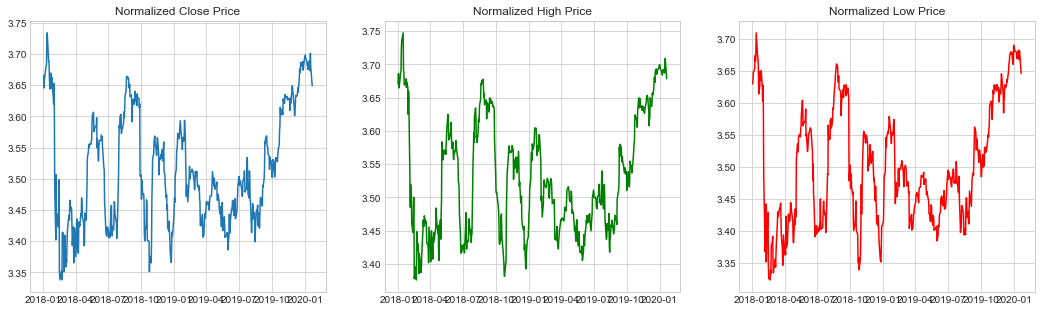

In [181]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

dte_df["close_log"] = np.log(dte_df["Close"])
dte_df["high_log"] = np.log(dte_df["High"])
dte_df["low_log"] = np.log(dte_df["Low"])

ax1.plot(dte_df["date"], dte_df["close_log"])
ax1.set_title("Normalized Close Price")
ax2.plot(dte_df["date"], dte_df["high_log"], color="g")
ax2.set_title("Normalized High Price")
ax3.plot(dte_df["date"], dte_df["low_log"], color="r")
ax3.set_title("Normalized Low Price")
plt.show()

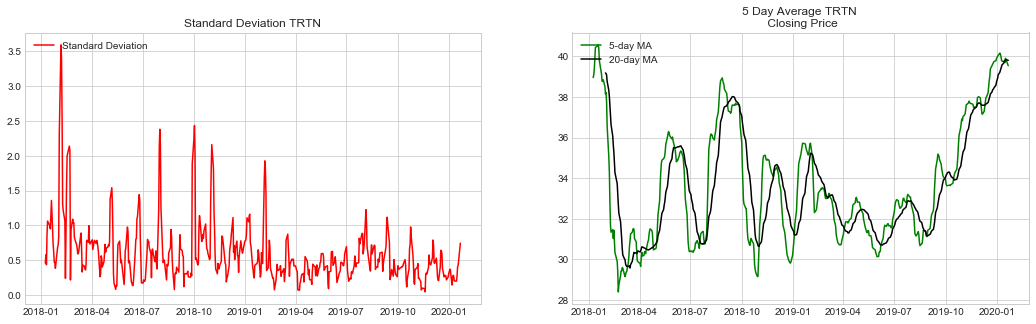

In [182]:
dte_df['std_close'] = dte_df["Close"].rolling(5).std()
dte_df['mean_close'] = dte_df["Close"].rolling(5).mean()
dte_df['twenty_mean_close'] = dte_df["Close"].rolling(20).mean()

f, (std_ax, avg_ax) = plt.subplots(1, 2, figsize=(18,5))

std_ax.plot(dte_df["date"], dte_df["std_close"], color="r", label="Standard Deviation")
std_ax.legend(loc="upper left")
std_ax.set_title(f"Standard Deviation {ticker}")

avg_ax.plot(dte_df["date"], dte_df["mean_close"], color="g", label="5-day MA")
avg_ax.plot(dte_df["date"], dte_df["twenty_mean_close"], color="k", label="20-day MA")
avg_ax.legend(loc="upper left")
avg_ax.set_title(f"5 Day Average {ticker} \n Closing Price")
plt.show()

In [183]:
m = Prophet()

# Drop the columns
ph_df = dte_df.drop(['Open', 'High', 'Low','Volume', 'close_log', 'high_log', 'mean_close', 'twenty_mean_close', 'low_log', 'std_close'], axis=1)
ph_df.rename(columns={'Close': 'y', 'date': 'ds'}, inplace=True)

ph_df.head()



,ds,y,Adj Close,month_year,10_d_avg,50_d_avg,200_d_avg
0,2018-01-02,39.090000,34.621300,2018-01,NaN,NaN,NaN
1,2018-01-03,38.310001,33.930470,2018-01,NaN,NaN,NaN
2,2018-01-04,38.810001,34.373314,2018-01,NaN,NaN,NaN
3,2018-01-05,39.000000,34.541592,2018-01,NaN,NaN,NaN
4,2018-01-08,39.580002,35.055283,2018-01,NaN,NaN,NaN


In [184]:
m.fit(ph_df)

future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
876,2021-01-16,65.392748,58.915504,72.123083
877,2021-01-17,65.509860,58.883269,72.436359
878,2021-01-18,63.574180,56.824577,70.463072
879,2021-01-19,63.780931,57.168957,70.721760
880,2021-01-20,63.793237,57.034133,70.563632


In [185]:
# Change dates from daily frequency to monthly frequency
forecast_monthly = forecast.resample('M', on='ds').mean()
forecast_monthly = forecast_monthly.reset_index() 


# Extract Year and Month and put it in a column.
forecast_monthly["month_int"] = forecast_monthly['ds'].dt.month
forecast_monthly["year"] = forecast_monthly['ds'].dt.year

forecast_monthly["month"] = np.nan
lst = [forecast_monthly]


for column in lst:
    column.loc[column["month_int"] == 1, "month"] = "January"
    column.loc[column["month_int"] == 2, "month"] = "February"
    column.loc[column["month_int"] == 3, "month"] = "March"
    column.loc[column["month_int"] == 4, "month"] = "April"
    column.loc[column["month_int"] == 5, "month"] = "May"
    column.loc[column["month_int"] == 6, "month"] = "June"
    column.loc[column["month_int"] == 7, "month"] = "July"
    column.loc[column["month_int"] == 8, "month"] = "August"
    column.loc[column["month_int"] == 9, "month"] = "September"
    column.loc[column["month_int"] == 10, "month"] = "October"
    column.loc[column["month_int"] == 11, "month"] = "November"
    column.loc[column["month_int"] == 12, "month"] = "December"
    
    
forecast_monthly['season'] = np.nan
lst2 = [forecast_monthly]

for column in lst2:
    column.loc[(column['month_int'] > 2) & (column['month_int'] <= 5), 'Season'] = 'Spring'
    column.loc[(column['month_int'] > 5) & (column['month_int'] <= 8), 'Season'] = 'Summer'
    column.loc[(column['month_int'] > 8) & (column['month_int'] <= 11), 'Season'] = 'Autumn'
    column.loc[column['month_int'] <= 2, 'Season'] = 'Winter'
    column.loc[column['month_int'] == 12, 'Season'] = 'Winter'
    


IndexError: single positional indexer is out-of-bounds

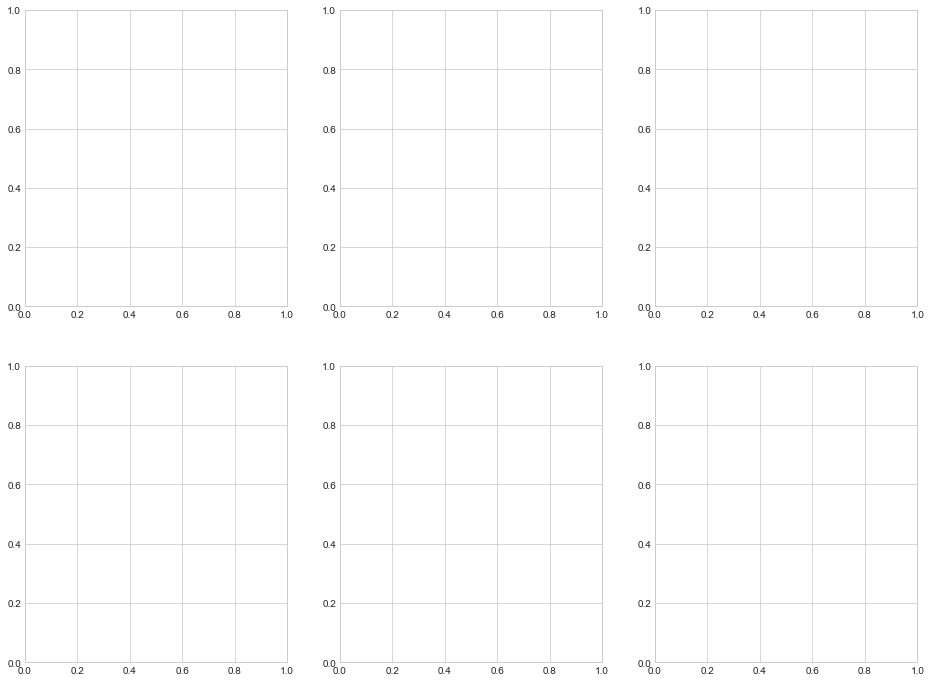

In [186]:
# Let's Create Seasonality Columns (Barplots that descripe the average trend per Season for each year)
# Create different axes by Year
df_2014 = forecast_monthly.loc[(forecast_monthly["year"] == 2014)]
df_2015 = forecast_monthly.loc[(forecast_monthly["year"] == 2015)]
df_2016 = forecast_monthly.loc[(forecast_monthly["year"] == 2016)]
df_2017 = forecast_monthly.loc[(forecast_monthly["year"] == 2017)]
df_2018 = forecast_monthly.loc[(forecast_monthly["year"] == 2018)]
df_2019 = forecast_monthly.loc[(forecast_monthly["year"] == 2019)]


f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16,12))



def linecolor14():
    if df_2014['trend'].iloc[0] <= df_2014['trend'].iloc[-1]:
        color = 'g'
    else: 
        color = 'r'
    return color
    
def linecolor15():
    if df_2015['trend'].iloc[0] <= df_2015['trend'].iloc[-1]:
        color = 'g'
    else: 
        color = 'r'
    return color

def linecolor16():
    if df_2016['trend'].iloc[0] <= df_2016['trend'].iloc[-1]:
        color = 'g'
    else: 
        color = 'r'
    return color

def linecolor17():
    if df_2017['trend'].iloc[0] <= df_2017['trend'].iloc[-1]:
        color = 'g'
    else: 
        color = 'r'
    return color
    

def linecolor18():
    if df_2018['trend'].iloc[0] <= df_2018['trend'].iloc[-1]:
        color = 'g'
    else: 
        color = 'r'
    return color
 
    
def linecolor19():
    if df_2019['trend'].iloc[0] <= df_2019['trend'].iloc[-1]:
        color = 'g'
    else: 
        color = 'r'
    return color
    


# Year 2014
sns.pointplot(x="Season", y="trend", 
                    data=df_2014, ax=ax1, color= linecolor14())

# Year 2015
sns.pointplot(x="Season", y="trend",
                    data=df_2015, ax=ax2, color=linecolor15())

# Year 2016
sns.pointplot(x="Season", y="trend",
                    data=df_2016, ax=ax3, color=linecolor16())


# Year 2017
sns.pointplot(x="Season", y="trend",
                    data=df_2017, ax=ax4, color=linecolor17())

# Year 2018
sns.pointplot(x="Season", y="trend",
                    data=df_2018, ax=ax5, color=linecolor18())

# Year 2019
sns.pointplot(x="Season", y="trend",
                    data=df_2019, ax=ax6, color=linecolor19())

ax1.set_title("Year 2014")
ax2.set_title("Year 2015")
ax3.set_title("Year 2016")
ax4.set_title("Year 2017")
ax5.set_title("Year 2018")
ax6.set_title("Year 2019")


plt.show()

<h3>References: </h3>
<a src="https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series"> Everything you can do with a time series </a> by Siddharth Yadav 
- A special thanks to Siddharth for publishing an amazing work in the Kaggle community. Definitely, will recommend his work for anyone interested in Time Series Forecasting.